In [3]:
import numpy as np
import cv2 # OpenCV-Python
import pandas as pd
from pandas import Series
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
def rotate_image(image, angle):
    if image.shape[1] > image.shape[0]:
        # Get the image size
        # No that's not an error - NumPy stores image matricies backwards
        image_size = (image.shape[1], image.shape[0])
        image_center = tuple(np.array(image_size) / 2)

        # Convert the OpenCV 3x2 rotation matrix to 3x3
        rot_mat = np.vstack(
            [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
        )

        rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

        # Shorthand for below calcs
        image_w2 = image_size[0] * 0.5
        image_h2 = image_size[1] * 0.5

        # Obtain the rotated coordinates of the image corners
        rotated_coords = [
            (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
            (np.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
            (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
            (np.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
        ]

        # Find the size of the new image
        x_coords = [pt[0] for pt in rotated_coords]
        x_pos = [x for x in x_coords if x > 0]
        x_neg = [x for x in x_coords if x < 0]

        y_coords = [pt[1] for pt in rotated_coords]
        y_pos = [y for y in y_coords if y > 0]
        y_neg = [y for y in y_coords if y < 0]

        right_bound = max(x_pos)
        left_bound = min(x_neg)
        top_bound = max(y_pos)
        bot_bound = min(y_neg)

        new_w = int(abs(right_bound - left_bound))
        new_h = int(abs(top_bound - bot_bound))

        # We require a translation matrix to keep the image centred
        trans_mat = np.matrix([
            [1, 0, int(new_w * 0.5 - image_w2)],
            [0, 1, int(new_h * 0.5 - image_h2)],
            [0, 0, 1]
        ])

        # Compute the tranform for the combined rotation and translation
        affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

        # Apply the transform
        result = cv2.warpAffine(
            image,
            affine_mat,
            (new_w, new_h),
            flags=cv2.INTER_LINEAR
        )

        return result
    else:
        return image

In [6]:
def rect_img(org_img):
    imgray = cv2.cvtColor(org_img,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray,100,100,0)
    image, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) > 1000:
            rect = cv2.minAreaRect(cnt)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            W = rect[1][0]
            H = rect[1][1]
            Xs = [i[0] for i in box]
            Ys = [i[1] for i in box]
            x1 = min(Xs)
            x2 = max(Xs)
            y1 = min(Ys)
            y2 = max(Ys)
            center = ((x1+x2)/2,(y1+y2)/2)
            size = (x2-x1, y2-y1)
            cropped = cv2.getRectSubPix(org_img, size, center)
#             print("box" , box)
#             im = cv2.drawContours(org_img,[box],0,(0,0,255),50)
#             [x, y, w, h] = cv2.boundingRect(cnt)
#             print(x,y,w,h)
#             return im
#             return imgray[y:y+h, x:x+w]
            return cropped

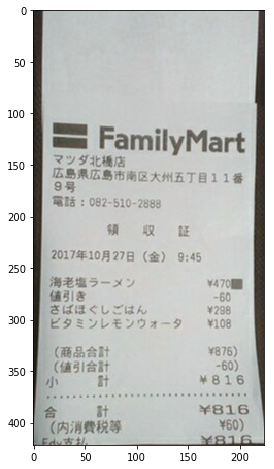

(422, 224, 3)


In [13]:
import cv2
org_img = cv2.imread("../../img/train/a5kdj9kr.jpg")
plt.figure(figsize=(8,8))
plt.plot(), plt.imshow(rotate_image(rect_img(org_img), -90), 'gray')
plt.show()

print(rotate_image(rect_img(org_img), -90).shape)

In [16]:
#!/usr/bin/python

import sys
import os

import cv2
import numpy as np

print('\ntextdetection.py')
print('       A demo script of the Extremal Region Filter algorithm described in:')
print('       Neumann L., Matas J.: Real-Time Scene Text Localization and Recognition, CVPR 2012\n')

img = cv2.imread("../../img/train/a5kdj9kr.jpg")
# for visualization
vis      = img.copy()

# Extract channels to be processed individually
channels = cv2.text.computeNMChannels(img)
# Append negative channels to detect ER- (bright regions over dark background)
cn = len(channels)-1
for c in range(0,cn):
    channels.append((255-channels[c]))

# Apply the default cascade classifier to each independent channel (could be done in parallel)
print("Extracting Class Specific Extremal Regions from "+str(len(channels))+" channels ...")
print("    (...) this may take a while (...)")
for channel in channels:

    erc1 = cv2.text.loadClassifierNM1('./trained_classifierNM1.xml')
    er1 = cv2.text.createERFilterNM1(erc1,16,0.00015,0.13,0.2,True,0.1)

    erc2 = cv2.text.loadClassifierNM2('./trained_classifierNM2.xml')
    er2 = cv2.text.createERFilterNM2(erc2,0.5)

    regions = cv2.text.detectRegions(channel,er1,er2)

    rects = cv2.text.erGrouping(img,channel,[r.tolist() for r in regions])
    #rects = cv2.text.erGrouping(img,channel,[x.tolist() for x in regions], cv.text.ERGROUPING_ORIENTATION_ANY,'../../GSoC2014/opencv_contrib/modules/text/samples/trained_classifier_erGrouping.xml',0.5)

    #Visualization
    for r in range(0,np.shape(rects)[0]):
        rect = rects[r]
        cv2.rectangle(vis, (rect[0],rect[1]), (rect[0]+rect[2],rect[1]+rect[3]), (0, 0, 0), 2)
        cv2.rectangle(vis, (rect[0],rect[1]), (rect[0]+rect[2],rect[1]+rect[3]), (255, 255, 255), 1)


#Visualization
plt.figure(figsize=(8,8))
plt.plot(), plt.imshow(vis, 'vis')
plt.show()

# print(rotate_image(rect_img(org_img), -90).shape)

# cv2.imshow("Text detection result", vis)
# cv.waitKey(0)


textdetection.py
       A demo script of the Extremal Region Filter algorithm described in:
       Neumann L., Matas J.: Real-Time Scene Text Localization and Recognition, CVPR 2012



AttributeError: module 'cv2.text' has no attribute 'computeNMChannels'